In [48]:
# Import libraries
import pandas as pd
from google.cloud import bigquery #pip install google-cloud-bigquery for SQL
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Setting secret credentials
from dotenv import load_dotenv #pip install python-dotenv
import os
load_dotenv()

True

In [49]:
project = os.getenv('BBC_PROJECT_ID')

In [50]:
# Initialize a BigQuery Client
client=bigquery.Client(project=project)

In [51]:
# Construct a reference to a dataset 
dataset_ref=client.dataset('bbc_news', project='bigquery-public-data')

In [52]:
# Fetch the dataset
dataset=client.get_dataset(dataset_ref)

In [53]:
# List all the tables
tables=list(client.list_tables(dataset))

In [54]:
# Print their names
list_of_tables=[table.table_id for table in tables]
print(list_of_tables)

['fulltext']


In [55]:
# Construct the reference to a table
table_ref=dataset_ref.table('fulltext')

In [56]:
# Get info on the columns
table=client.get_table(table_ref)
table.schema

[SchemaField('body', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('filename', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('category', 'STRING', 'NULLABLE', None, None, (), None)]

In [58]:
query = """
SELECT category, title
FROM  `bigquery-public-data.bbc_news.fulltext`
WHERE category = 'politics'
ORDER BY title ASC
"""
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
# Run dry run
dry_run_query_job = client.query(query, job_config=dry_run_config)

# Check the number of bytes the query would process
print(f"This query will process {dry_run_query_job.total_bytes_processed} bytes.")


This query will process 95295 bytes.


In [ ]:
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10) # 1MB limit  # 10 GB limit - maximum_bytes_billed=10**10
safe_query_job=client.query(query, job_config=safe_config)
safe_query_job.to_dataframe()

/Users/anna_verbytska/Documents/BBC-News/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,category,title
0,politics,'Best person' for top legal job
1,politics,'Debate needed' on donations cap
2,politics,'Debate needed' on donations cap
3,politics,'EU referendum could cost £80m'
4,politics,'Errors' doomed first Dome sale
...,...,...
412,politics,Whitehall shredding increasing - Tories
413,politics,Will Tory tax cuts lift spirits?
414,politics,Will the Budget bring out smiling voters?
415,politics,Women MPs reveal sexist taunts


In [ ]:
# Put the table to a DataFrame and preview
df = client.list_rows(table).to_dataframe()
df.head(20)

/Users/anna_verbytska/Documents/BBC-News/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,body,title,filename,category
0,The global web blog community is being called ...,Global blogger action day called,bbc/tech/016.txt,tech
1,"The ""digital divide"" between rich and poor nat...",Global digital divide 'narrowing',bbc/tech/033.txt,tech
2,The current slew of sports games offers unpara...,Sporting rivals go to extra time,bbc/tech/056.txt,tech
3,Writing a Microsoft Word document can be a dan...,Warning over Windows Word files,bbc/tech/086.txt,tech
4,"Aid workers trying to house, feed and clothe m...",Satellite mapping aids Darfur relief,bbc/tech/223.txt,tech
5,DVDs will be harder to copy thanks to new anti...,DVD copy protection strengthened,bbc/tech/326.txt,tech
6,UK mobile owners continue to break records wit...,Text message record smashed again,bbc/tech/372.txt,tech
7,Internet TV has been talked about since the st...,TV's future down the phone line,bbc/tech/394.txt,tech
8,Intel has unveiled research that could mean da...,Intel unveils laser breakthrough,bbc/tech/019.txt,tech
9,BBC Sport unveils its new analysis tool Piero ...,Piero gives rugby perspective,bbc/tech/028.txt,tech


### EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2225 non-null   object
 1   title     2225 non-null   object
 2   filename  2225 non-null   object
 3   category  2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
# Check for duplicated articles
df.duplicated(subset=None, keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
2220    False
2221    False
2222    False
2223    False
2224    False
Length: 2225, dtype: bool

In [ ]:
# Check one article
for idx in df.sample(3).index:
    text = df.iloc[idx]  
    print("Body: {}:".format(text.body))
    print("Title: {}\n".format(text.title))
    print("Category: {}".format(text.category))

Body: Aston Villa's Thomas Hitzlsperger is waiting to learn the future of manager David O'Leary before committing himself to a new contract with the club.

O'Leary has been in talks over a new deal and he said: "I had a message from Thomas' agent asking me what the news was on myself. "He wants to find out before he goes into discussions over Thomas. "The reason Thomas is not speaking to the club is because the agent wants to see the outcome of what happens to me." Hitzlsperger's current deal expires in the summer and he has been offered a new deal by the Midlands club. The German international is understood to be keen to remain at Villa, despite interest in his native country from Hamburg. But he wants assurances that O'Leary will also be committing himself long-term because negotiations over a new three-and-a-half-year contract appear to have stalled.

O'Leary wants his backroom staff - assistant manager Roy Aitken and fitness coach Steve McGregor - to also be given satisfactory deal

In [ ]:
# Count unique categories
df["category"].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [ ]:
# Visualize categories to check for imbalances
fig = px.histogram(df, x='category', color='category', 
                   title="Article Count per Category", 
                   labels={"category": "Category"}, 
                   color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(showlegend=False, height=700, width=1100)
fig.show()

In [ ]:
# The count of words in the longest article across categories
categories=['tech', 'sport', 'business', 'politics', 'entertainment']
print("The longest article by category (Word Count):")
for category in categories:
    max_words = df[df['category'] == category]['body'].apply(lambda x: len(x.split())).max()
    print(f"{category.capitalize()}: {max_words} words")


The longest article by category (Word Count):
Tech: 2964 words
Sport: 1656 words
Business: 885 words
Politics: 4428 words
Entertainment: 3477 words


In [ ]:

# The count of words in the shortest article across categories
print("The shortest article by category (Word Count):")
for category in categories:
    min_words = df[df['category'] == category]['body'].apply(lambda x: len(x.split())).min()
    print(f"- {category.capitalize():<15}: {min_words} words")

The shortest article by category (Word Count):
- Tech           : 157 words
- Sport          : 108 words
- Business       : 136 words
- Politics       : 84 words
- Entertainment  : 138 words


Note: the category of politics has the longest and the shortest articles

In [ ]:
# Check the shortest article in the politics section
shortest_article = df[df['category'] == 'politics'].loc[lambda x: x['body'].apply(lambda y: len(y.split())).idxmin(), 'body']
print(f"Sample article text:\n{shortest_article}")

Sample article text:
Ex-Home Secretary David Blunkett has given fresh clues that the general election will be announced on Monday.

He told BBC Radio Five Live: "I'm out in my constituency getting ready for what we presume will be an announcement very shortly at the weekend." He clarified that he meant he would be in his Sheffield seat this weekend, not that he expected an election call then. Tony Blair is tipped to ask the Queen on Monday to dissolve Parliament ready for a 5 May poll.



In [ ]:
# Check the longest article in the politics section
longest_article = df[df['category'] == 'politics'].loc[lambda x: x['body'].apply(lambda y: len(y.split())).idxmax(), 'body']
print(f"Sample article text:\n{longest_article}")

Sample article text:
The Lord Chancellor has defended government plans to introduce control orders to keep foreign and British terrorist suspects under house arrest, where there isn't enough evidence to put them on trial.

Lord Falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties. But thriller writer Frederick Forsyth tells BBC News of his personal response to the move.



There is a mortal danger aimed at the heart of Britain. Or so says Home Secretary Charles Clarke. My reaction? So what? It is not that I am cynical or just do not care. I care about this country very much.

But in the 66 years that I have been alive, there has not been one hour, of one day, of one month, of one year, when there has not been a threat aimed at us. My point is, the British have always coped without becoming a dictatorship. We have coped with fear without becoming a state based 

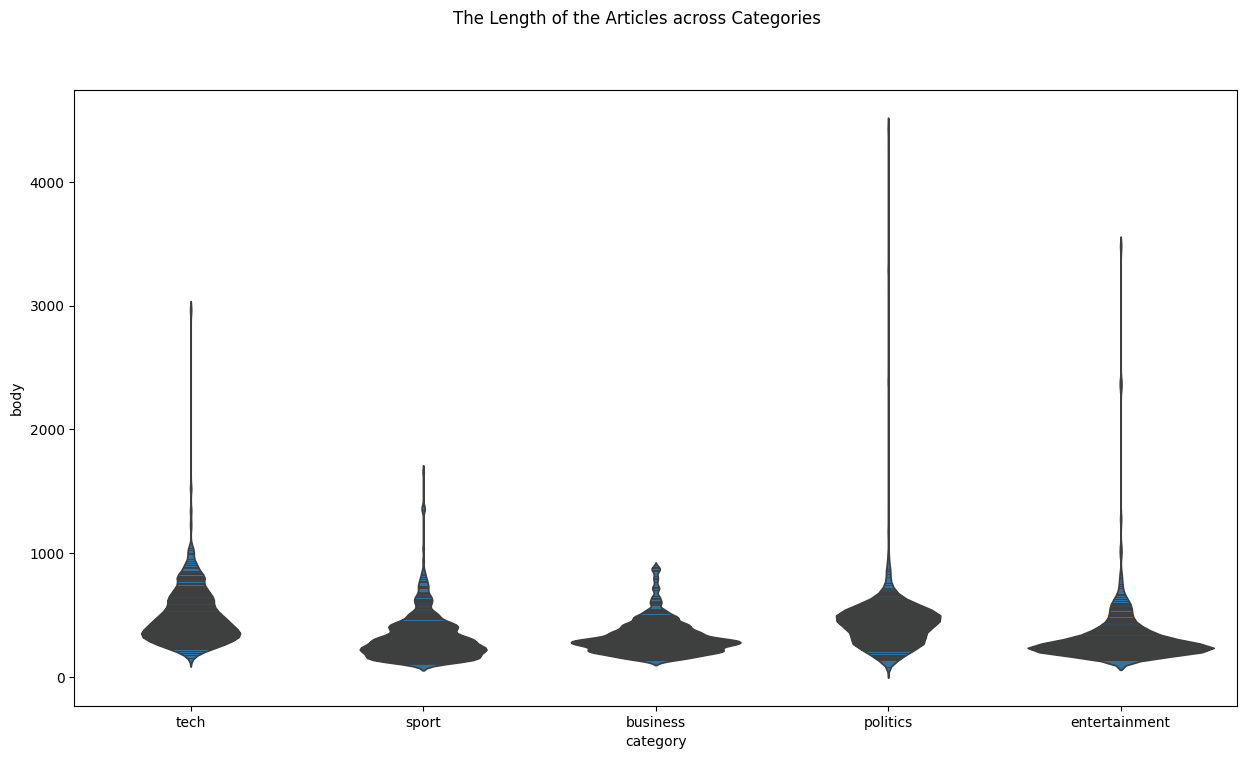

In [ ]:
# Visualize length of articles across the categories for balance
fig, axs = plt.subplots(figsize=(15,8))
fig.suptitle("The Length of the Articles across Categories")
axs=sns.violinplot( x=df['category'], y=df["body"].apply(lambda x : len(x.split())), bw_adjust=.5, inner="stick")
plt.show()

In [ ]:
# Create a box plot for the length of articles across categories
fig = px.box(df, x='category', y=df['body'].apply(lambda x: len(x.split())), 
             title="The Length of the Articles across Categories", 
             labels={"category": "Category", "y": "Word Count"},
             color='category',
             points="all")  # to show individual points similar to "inner=stick"

fig.update_traces(boxmean='sd')  # Show standard deviation (can be changed as needed)
fig.update_layout(showlegend=False, height=700, width=1100)

fig.show()


Note: further topic modelling and sentiment analysis may be biased by skewed article length.

LDA: Longer texts might dominate the topic distribution, while shorter texts may not provide enough data for clear topic identification.
BERTopic: even though it is a more advanced technique, extremely long texts may dominate the embeddings and clustering process, influencing the learned topics. Shorter texts might have less impact on the topic distribution, which can bias the model.

Possible solutions: 
normalization for LDA: stopword removal, stemming, lemmatization, truncation or better filtering short docs (max_words=500 or min_words=20)
normalization for BERTopic: chunking long texts and treating them as separate docs, embed the chunks, filtering very short texts.
